# TM10007 Assignment template

In [153]:
# Run this to use from colab environment
!pip install -q --upgrade git+https://github.com/karinvangarderen/tm10007_project.git

In [0]:
# General packages
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn

# Classifiers
from sklearn import model_selection
from sklearn import metrics
from sklearn.model_selection import LeaveOneOut
from sklearn.ensemble import RandomForestClassifier
from sklearn import neighbors
from sklearn import svm
from sklearn import preprocessing
import numpy as np
from sklearn.model_selection import KFold
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.datasets import make_classification
from sklearn.model_selection import RandomizedSearchCV 
from sklearn.utils.fixes import loguniform
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA


from sklearn.linear_model import Lasso, RidgeClassifier
from sklearn.feature_selection import SelectFromModel

# Data loading and cleaning

Some functions

In [0]:
# Some functions we will use


def colorplot(clf, ax, x, y, h=100):
    '''
    Overlay the decision areas as colors in an axes.
    
    Input:
        clf: trained classifier
        ax: axis to overlay color mesh on
        x: feature on x-axis
        y: feature on y-axis
        h(optional): steps in the mesh
    '''
    # Create a meshgrid the size of the axis
    xstep = (x.max() - x.min() ) / 20.0
    ystep = (y.max() - y.min() ) / 20.0
    x_min, x_max = x.min() - xstep, x.max() + xstep
    y_min, y_max = y.min() - ystep, y.max() + ystep
    h = max((x_max - x_min, y_max - y_min))/h
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    if hasattr(clf, "decision_function"):
        Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    else:
        Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])
    if len(Z.shape) > 1:
        Z = Z[:, 1]
    
    # Put the result into a color plot
    cm = plt.cm.RdBu_r
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)
    del xx, yy, x_min, x_max, y_min, y_max, Z, cm

def plot_learning_curve(estimator, title, X, y, axes, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    axes : array of 3 axes, optional (default=None)
        Axes to use for plotting the curves.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """

    axes.set_title(title)
    if ylim is not None:
        axes.set_ylim(*ylim)
    axes.set_xlabel("Training examples")
    axes.set_ylabel("Score")

    train_sizes, train_scores, test_scores  = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Plot learning curve
    axes.grid()
    axes.fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes.fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes.plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes.plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes.legend(loc="best")

    return plt

def plot_roc_curve(y_score, y_truth):
    '''
    Plot an ROC curve.
    '''
    # Only take scores for class = 1
    y_score = y_score[:, 1]
    
    # Compute ROC curve and ROC area for each class
    fpr, tpr, _ = roc_curve(y_truth, y_score)
    roc_auc = auc(fpr, tpr)
    
    # Plot the ROC curve
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

Data loading and handling missing data. 

In [156]:
# Data loading functions. 
from adni.load_data import load_data 

data = load_data()
print(data.head())
print(f'The number of samples: {len(data.index)}')
print(f'The number of columns: {len(data.columns)}')
#data_missing = data.isnull()
#print(data_missing.index[data_missing == True])

# Creating vector of labels
data_no_label = data.drop(columns='label')
print(f'The number of features: {len(data_no_label.columns)}')
x = data_no_label
y = data['label']

# Split data
X_train, X_test, y_train, y_test = model_selection.train_test_split(x, y, test_size=0.2)

def removezeros(X):
   X_nozeros = X.loc[:, (X != 0).any(axis=0)]
   return X_nozeros

X_train_df = removezeros(X_train)
X_test_df = removezeros(X_test)
print(f'The number of samples: {len(X_train_df.index)}')
print(f'The number of columns: {len(X_train_df.columns)}')
X_train = X_train_df.values
X_test = X_test_df.values

x_nan = np.isnan(X_train)
print(f'The number of found NaN is: {np.sum(x_nan)}')
#x_zero = np.where(X_train == 0)[0]
#print(f'The number of found zeros is: {len(x_zero)}')

y_train_bin = preprocessing.label_binarize(y_train,['AD','CN'])
y_train_bin = [i[0] for i in y_train_bin]
y_test_bin = preprocessing.label_binarize(y_test,['AD','CN'])
y_test_bin = [i[0] for i in y_test_bin]
#print(y_train_bin)

                     hf_energy  ...  vf_Frangi_inner_std_SR(1.0, 10.0)_SS2.0
ID                              ...                                         
0_002_S_0413_bl_0  5403.229408  ...                             4.207831e-10
0_002_S_0559_bl_0   922.459760  ...                             3.137258e-10
0_002_S_0619_bl_0  1674.765276  ...                             4.219847e-10
0_002_S_0685_bl_0  3443.797200  ...                             5.954654e-11
0_002_S_0816_bl_0   914.469846  ...                             4.174750e-10

[5 rows x 268 columns]
The number of samples: 855
The number of columns: 268
The number of features: 267
The number of samples: 684
The number of columns: 263
The number of found NaN is: 0


# Feature scaling and selection


Selected 132 from 263 features.


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27.292425956550424, tolerance: 0.016573684210526324
  positive)


'\n# Create the RFE object and compute a cross-validated score.\nsvc = SVC(kernel="linear")\n# The "accuracy" scoring is proportional to the number of correct\n# classifications\nrfecv = RFECV(estimator=svc, step=1, cv=StratifiedKFold(2),\n              scoring=\'roc_auc\')\nselect = rfecv.fit(X_train_scaled, y_train)\n\n# Plot number of features VS. cross-validation scores\nplt.figure()\nplt.xlabel("Number of features selected")\nplt.ylabel("Cross validation score (nb of correct classifications)")\nplt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)\nplt.show()\n\nprint("Optimal number of features : %d" % rfecv.n_features_)\n'

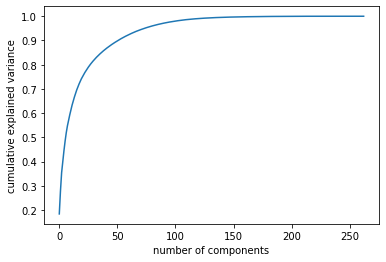

In [157]:
# Scaling of features
scaler = preprocessing.StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Feature selection - L1 method
selector = SelectFromModel(estimator=Lasso(alpha=10**(-10), random_state=42), threshold='median')
selector.fit(X_train_scaled, y_train_bin)
n_original = X_train_scaled.shape[1]
X_train_test = selector.transform(X_train_scaled)
n_selected = X_train_test.shape[1]
print(f"Selected {n_selected} from {n_original} features.")

# PCA
pca = PCA().fit(X_train_scaled)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

pca = PCA(n_components=132)
pca = pca.fit(X_train_scaled)
X_train = pca.transform(X_train_scaled)
X_test = pca.transform(X_test_scaled)



"""
# Create the RFE object and compute a cross-validated score.
svc = SVC(kernel="linear")
# The "accuracy" scoring is proportional to the number of correct
# classifications
rfecv = RFECV(estimator=svc, step=1, cv=StratifiedKFold(2),
              scoring='roc_auc')
select = rfecv.fit(X_train_scaled, y_train)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

print("Optimal number of features : %d" % rfecv.n_features_)
"""

In [158]:
"""
# Get new X_train with only important features 
features = X_train_df * select.support_
x_train_df = removezeros(features)
x_train = x_train_df.values
"""

'\n# Get new X_train with only important features \nfeatures = X_train_df * select.support_\nx_train_df = removezeros(features)\nx_train = x_train_df.values\n'

In [159]:

# Train Classifier  
# defining parameter range 
param_grid = {'C': loguniform(1e0, 1e3), 
              'gamma': loguniform(1e-4, 1e0), 
              'kernel': ['rbf','poly', 'linear']}  
  
grid = RandomizedSearchCV(SVC(probability=True), param_grid, n_iter=10, refit = True, verbose = 3, random_state=42) 
  
# fitting the model for grid search 
grid.fit(X_train, y_train)

print("The best classifier is: ", grid.best_estimator_)



Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] C=13.292918943162162, gamma=0.6351221010640693, kernel=linear ...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=13.292918943162162, gamma=0.6351221010640693, kernel=linear, score=0.752, total=  12.4s
[CV] C=13.292918943162162, gamma=0.6351221010640693, kernel=linear ...


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   12.4s remaining:    0.0s


[CV]  C=13.292918943162162, gamma=0.6351221010640693, kernel=linear, score=0.679, total=   6.2s
[CV] C=13.292918943162162, gamma=0.6351221010640693, kernel=linear ...


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   18.6s remaining:    0.0s


[CV]  C=13.292918943162162, gamma=0.6351221010640693, kernel=linear, score=0.774, total=   9.0s
[CV] C=13.292918943162162, gamma=0.6351221010640693, kernel=linear ...
[CV]  C=13.292918943162162, gamma=0.6351221010640693, kernel=linear, score=0.810, total=  15.1s
[CV] C=13.292918943162162, gamma=0.6351221010640693, kernel=linear ...
[CV]  C=13.292918943162162, gamma=0.6351221010640693, kernel=linear, score=0.735, total=   9.9s
[CV] C=218.3096839052459, gamma=0.02440060709081752, kernel=poly .....
[CV]  C=218.3096839052459, gamma=0.02440060709081752, kernel=poly, score=0.766, total=   0.3s
[CV] C=218.3096839052459, gamma=0.02440060709081752, kernel=poly .....
[CV]  C=218.3096839052459, gamma=0.02440060709081752, kernel=poly, score=0.708, total=   0.3s
[CV] C=218.3096839052459, gamma=0.02440060709081752, kernel=poly .....
[CV]  C=218.3096839052459, gamma=0.02440060709081752, kernel=poly, score=0.788, total=   0.3s
[CV] C=218.3096839052459, gamma=0.02440060709081752, kernel=poly .....
[CV]

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  4.6min finished


The best classifier is:  SVC(C=4.335281794951563, break_ties=False, cache_size=200, class_weight=None,
    coef0=0.0, decision_function_shape='ovr', degree=3,
    gamma=0.0005337032762603955, kernel='rbf', max_iter=-1, probability=True,
    random_state=None, shrinking=True, tol=0.001, verbose=False)


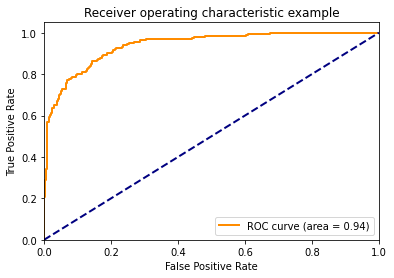

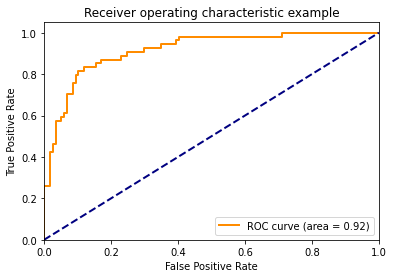

TypeError: ignored

In [160]:

from sklearn.metrics import roc_curve, auc
from scipy import interp
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize
score_train = grid.best_estimator_.predict_proba(X_train)
score_test = grid.best_estimator_.predict_proba(X_test)
plot_roc_curve(score_train, y_train_bin)
plot_roc_curve(score_test, y_test_bin)

y_pred = grid.best_estimator_.predict(X_test)
y_score = score_test[:, 1]
#if hasattr(grid.best_estimator_, 'predict_proba'):
    # The first column gives the probability for class = 0, so we take
    # the second which gives the probability class = 1:
        #y_score = score_test[:, 1]
   # else:
    #   y_score = y_pred

auc=metrics.roc_auc_score(y_test_bin, y_score)
accuracy=metrics.accuracy_score(y_test_bin, y_pred)
F1=metrics.f1_score(y_test_bin,y_pred)
precision=metrics.precision_score(y_test_bin,y_pred)
recall=metrics.recall_score(y_test_bin, y_pred)
# accuracy, AUC, f1score, precision, recall
print(type(clf))
print('Acc SVM:' +str(accuracy))
print('AUC SVM:' +str(auc))
print('F1 SVM:' +str(F1))
print('precision SVM:' +str(precision))
print('recall SVM:' +str(recall))


In [0]:
# kNN
from scipy.stats import randint
from sklearn.model_selection import GridSearchCV
kNN_parameters = {'n_neighbors': list(range(1,101)), 
                   'weights':  ['uniform', 'distance'],
                   'metric': ['euclidean', 'manhattan']}

grid = RandomizedSearchCV(KNeighborsClassifier(), kNN_parameters, refit = True, n_iter=10, random_state=42, verbose = 3)  
# fitting the model for grid search 
grid.fit(X_train, y_train)

print("The best classifier is: ", grid.best_estimator_)

score_train = grid.best_estimator_.predict_proba(X_train)
score_test = grid.best_estimator_.predict_proba(X_test)
plot_roc_curve(score_train, y_train_bin)
plot_roc_curve(score_test, y_test_bin)

y_pred = grid.best_estimator_.predict(X_test)

auc=metrics.roc_auc_score(y_test_bin, score_test)
accuracy=metrics.accuracy_score(y_test_bin, y_pred)
F1=metrics.f1_score(y_test_bin,y_pred)
precision=metrics.precision_score(y_test_bin,y_pred)
recall=metrics.recall_score(y_test_bin, y_pred)
# accuracy, AUC, f1score, precision, recall
print(type(clf))
print('Acc kNN:' +str(accuracy))
print('AUC kNN:' +str(auc))
print('F1 kNN:' +str(F1))
print('precision kNN:' +str(precision))
print('recall kNN:' +str(recall))


In [0]:
# Random forest
forest_parameters = {'n_estimators': list(range(50,301)), 
                   'criterion':  ['gini', 'entropy'],
                   'max_depth': [4, 5, 6, 7, 8, 9, 10],
                   'max_features': ['auto','sqrt','log2']}

grid = RandomizedSearchCV(RandomForestClassifier(), forest_parameters, refit = True, n_iter=10, random_state=42, verbose = 3)  
# fitting the model for grid search 
grid.fit(X_train, y_train)

print("The best classifier is: ", grid.best_estimator_)

score_train = grid.best_estimator_.predict_proba(X_train)
score_test = grid.best_estimator_.predict_proba(X_test)
plot_roc_curve(score_train, y_train_bin)
plot_roc_curve(score_test, y_test_bin)

y_pred = grid.best_estimator_.predict(X_test)

auc=metrics.roc_auc_score(y_test_bin, score_test)
accuracy=metrics.accuracy_score(y_test_bin, y_pred)
F1=metrics.f1_score(y_test_bin,y_pred)
precision=metrics.precision_score(y_test_bin,y_pred)
recall=metrics.recall_score(y_test_bin, y_pred)
# accuracy, AUC, f1score, precision, recall
print(type(clf))
print('Acc RF:' +str(accuracy))
print('AUC RF:' +str(auc))
print('F1 RF:' +str(F1))
print('precision RF:' +str(precision))
print('recall RF:' +str(recall))